### Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import GlorotUniform

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-03-02 20:31:42.549388: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 20:31:42.576991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-02 20:31:42.577014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-02 20:31:42.577704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 20:31:42.582172: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


### Read file path and labels to list

In [2]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "training_norm.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

# there is one speed > 1. So change it.
csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

csv_df.drop(columns=["speed"], inplace=True)

display(csv_df)

,angle
image_id,
1,0.4375
2,0.8125
3,0.4375
4,0.6250
5,0.5000
...,...
13794,0.6250
13795,0.4375
13796,0.5625


Check the data

(array([  88.,  197.,  104.,  641., 1467., 3655., 3970., 2123., 1448.,
         100.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

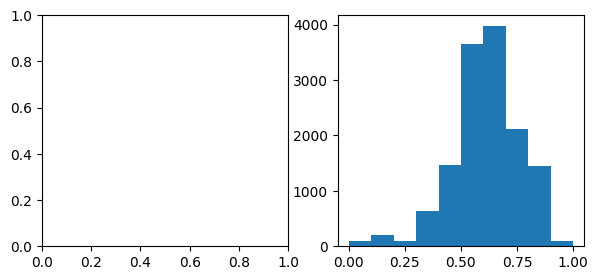

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[1].hist(csv_df["angle"])

0.00000 60
0.06250 28
0.12500 99
0.18750 98
0.25000 104
0.31250 213
0.37500 428
0.43750 1467
0.50000 2046
0.56250 1609
0.62500 1963
0.68750 2007
0.75000 2123
0.81250 1147
0.87500 301
0.93750 65
1.00000 35
{0.0: 60, 0.0625: 28, 0.125: 99, 0.1875: 98, 0.25: 104, 0.3125: 213, 0.375: 428, 0.4375: 1467, 0.5: 2046, 0.5625: 1609, 0.625: 1963, 0.6875: 2007, 0.75: 2123, 0.8125: 1147, 0.875: 301, 0.9375: 65, 1.0: 35}


<BarContainer object of 17 artists>

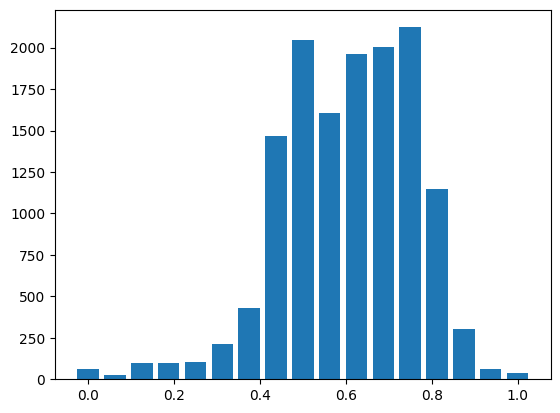

In [4]:
angle = csv_df["angle"]

df = pd.DataFrame(angle)
bins = np.unique(angle)
c = df["angle"].value_counts()

angle_count = {}

for bin in bins:
    angle_count[bin] = c[bin]

key, value = list(angle_count.keys()), list(angle_count.values())

for i in range(len(key)):
    print(f"{key[i]:.5f} {value[i]}")

print(angle_count)

plt.bar(key, value, width=0.05)

In [5]:
# for rs in range(10000):
#     X = np.array(csv_df.index)
#     y = np.array(csv_df['angle'])
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=rs)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(0.15/0.85), random_state=rs)

#     # print(X_train.shape)
#     # print(X_val.shape)
#     # print(X_test.shape)
#     # print(X.shape)

#     train_count = pd.Series(y_train).value_counts()
#     train_count = train_count / sum(train_count) * 100
#     # val_count = pd.Series(y_val).value_counts()
#     # val_count = val_count / sum(val_count) * 100
#     # test_count = pd.Series(y_test).value_counts()
#     # test_count = test_count / sum(test_count) * 100

#     ori_count = pd.Series(y).value_counts()
#     ori_count = ori_count / sum(ori_count) * 100

#     diff = (sum(abs(train_count-ori_count)))

#     if (diff < 0.6):
#         print(f"random state: {rs}")
#         print(diff)

#     bar_width = 0.015
#     # plt.bar(val_count.index-bar_width, train_count, width=bar_width)
#     # plt.bar(train_count.index, train_count, width=bar_width)
#     # plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
#     # plt.bar(test_count.index+bar_width, train_count, width=bar_width)

11724 2069


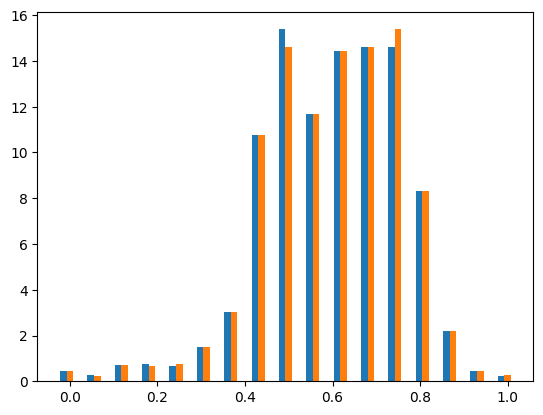

In [6]:
rs = 5695
X = np.array(csv_df.index)
y = np.array(csv_df["angle"])
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.15, random_state=rs
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=(0.15 / 0.85), random_state=rs
# )
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=rs
)


train_count = pd.Series(y_train).value_counts()
train_count = train_count / sum(train_count) * 100
val_count = pd.Series(y_val).value_counts()
val_count = val_count / sum(val_count) * 100
# test_count = pd.Series(y_test).value_counts()
# test_count = test_count / sum(test_count) * 100

ori_count = pd.Series(y).value_counts()
ori_count = ori_count / sum(ori_count) * 100

diff = sum(abs(train_count - ori_count))

if diff < 0.7:
    print(f"random state: {rs}")
    print(diff)

bar_width = 0.015
plt.bar(val_count.index - bar_width, train_count, width=bar_width)
plt.bar(train_count.index, train_count, width=bar_width)
# plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
# plt.bar(test_count.index + bar_width, train_count, width=bar_width)

print(len(X_train), len(X_val))

In [7]:
train_count = pd.Series(y_train).value_counts().sort_index()
train_total = np.sum(train_count)

weight = train_total / (len(train_count) * train_count)
weight = weight / min(weight)

print(weight)


lower, upper = (0, 5)
threshold = 12

def tune_weight(x):
  if x < lower:
    return lower
  elif x < threshold:
    return 1.0
  else:
    return float(upper)

weight = weight.apply(tune_weight)
weight.iloc[5] = upper/2
weight.iloc[-3] = upper/4
weight.iloc[-1] = upper*1.5
weight.iloc[1] = upper*3
weight.iloc[6] = weight.iloc[6] * 1.3
weight.iloc[-3:-1] = weight.iloc[-3:-1] * 1.5


# weight = weight.apply(lambda x: upper if x > upper else x)
# weight = weight.apply(lambda x: lower if x < lower else x)


p_for_random_choice = weight[y_train].values

p_for_random_choice = p_for_random_choice / sum(p_for_random_choice)

print(weight)

0.0000    34.018868
0.0625    72.120000
0.1250    21.211765
0.1875    22.822785
0.2500    19.813187
0.3125    10.244318
0.3750     5.107649
0.4375     1.432089
0.5000     1.052539
0.5625     1.317982
0.6250     1.066864
0.6875     1.052539
0.7500     1.000000
0.8125     1.853032
0.8750     7.042969
0.9375    33.388889
1.0000    54.636364
Name: count, dtype: float64
0.0000     5.000
0.0625    15.000
0.1250     5.000
0.1875     5.000
0.2500     5.000
0.3125     2.500
0.3750     1.300
0.4375     1.000
0.5000     1.000
0.5625     1.000
0.6250     1.000
0.6875     1.000
0.7500     1.000
0.8125     1.000
0.8750     1.875
0.9375     7.500
1.0000     7.500
Name: count, dtype: float64


In [8]:
# # Define generator for weighted sampling
# def sample_generator(X, y, sample_probs):
#     idx = np.random.choice(len(y), p=sample_probs)  # Sample index
#     return X[idx], y[idx]


# X_train_os = []
# y_train_os = []

# for i in range(10240):
#     X_sampled, y_sampled = sample_generator(X_train, y_train, p_for_random_choice)
#     X_train_os.append(X_sampled)
#     y_train_os.append(y_sampled)

# # for i in range(10):
# #     print(X_train_os[i], y_train_os[i])
# #     print(csv_df.loc[X_train_os[i]]['angle'])

# # print(pd.Series(y_train).value_counts().sort_index())

# # print(pd.Series(y_train_os).value_counts().sort_index())

# y_train_os_count = pd.Series(y_train_os).value_counts().sort_index()

# plt.bar(list(y_train_os_count.index), y_train_os_count, width=0.04)
# plt.title("Over sampled")

In [9]:
sample_probs_tensor = tf.constant(p_for_random_choice, dtype=tf.float32)

X_train_tensor = tf.constant(X_train, dtype=tf.int32)
y_train_tensor = tf.constant(y_train, dtype=tf.float32)

NUM_SAMPLES = 64*175

def sample_indices():
    return tf.random.categorical(tf.math.log([sample_probs_tensor]), NUM_SAMPLES)[0]

sampled_indices = sample_indices()

X_train_os = tf.gather(X_train_tensor, sampled_indices)
y_train_os = tf.gather(y_train_tensor, sampled_indices)

train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))

print(NUM_SAMPLES)

2025-03-02 20:31:45.751320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 20:31:45.787461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 20:31:45.787510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 20:31:45.792730: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-02 20:31:45.792771: I external/local_xla/xla/stream_executor

11200


2025-03-02 20:31:46.237925: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [10]:
ids = []
angles = []
for id, angle in train_ds:
    ids.append(id.numpy())
    angles.append(angle.numpy())

Text(0.5, 1.0, 'Distribution of angles after oversampling')

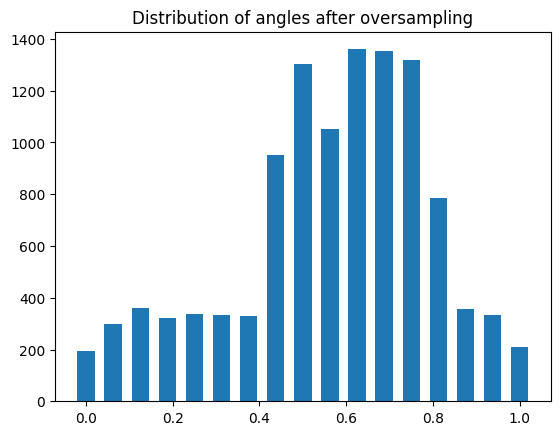

In [11]:
y_count = pd.Series(angles).value_counts().sort_index()
plt.bar(y_count.index, y_count, width=0.04)
plt.title("Distribution of angles after oversampling")

In [12]:
# X_train_os_path = [
#     os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_train_os
# ]
X_val_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_val
]

In [13]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path, angle):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, angle

def image_id_to_path(image_id, angle):
    image_path = tf.strings.join([training_data_dir, '/', tf.as_string(image_id), ".png"])  # Assuming images are .jpg
    return image_path, angle

In [14]:
# train_ds = tf.data.Dataset.from_tensor_slices((X_train_os_path, y_train_os))
train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))
train_ds = train_ds.map(image_id_to_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(train_ds_length)
val_ds_length = tf.data.experimental.cardinality(val_ds).numpy()
print(val_ds_length)

11200
2069


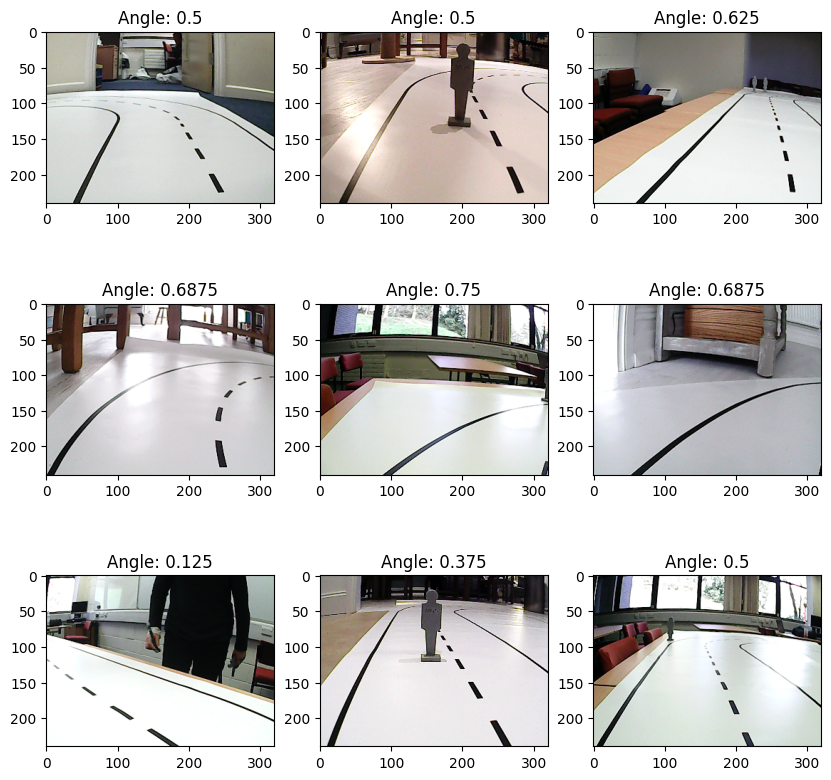

In [15]:
plt.figure(figsize=(10, 10))
i = 0

for image, angle in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    angle = angle.numpy()
    plt.title(f"Angle: {angle}")
    i += 1

In [16]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

In [17]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, angle, seed=None):
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)
    image = tf.image.stateless_random_jpeg_quality(image, 80, 100, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, angle

Test augment function

20
Augmented image shape: (240, 320, 3)


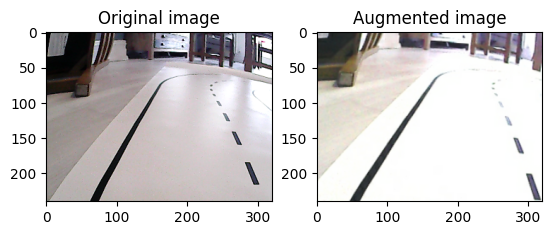

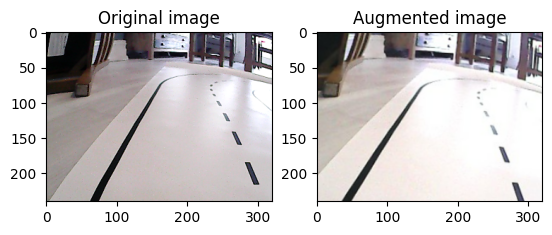

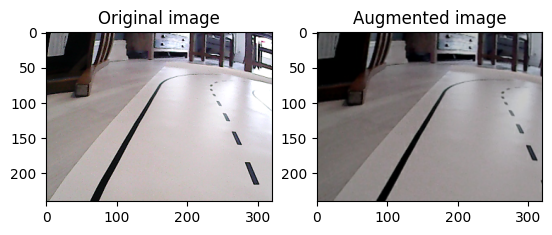

In [18]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, angle in train_ds.skip(skip).take(1):
        augmented_image, angle = augment(image, angle, None)
        visualise(image, augmented_image)

for image, angle in train_ds.take(1):
    aug_image, aug_angle = augment(image, angle)
    print(f"Augmented image shape: {aug_image.shape}")

In [19]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
# def enhance_red(image, speed):
#     r, g, b = tf.split(image, num_or_size_splits=3, axis=-1)
#     r_mask = tf.logical_and((r*0.9 > g), (r*0.9 > b))
#     g_mask = tf.logical_and((g > r), (g > b))
#     b_mask = tf.logical_and((b > r), (b > g))
#     r = tf.where(r_mask, tf.clip_by_value(r * 1.5, 0.0, 1.0), r)
#     # g = g**2
#     # b = b**2
#     image = tf.concat([r, g, b], axis=-1)
#     return image, speed

# trian_ds = train_ds.map(enhance_red, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(enhance_red, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
def scale_ds(image, speed):
    # Range of input image: [0, 1]
    return image * 2 - 1.0, speed       # [-1, 1]
    # return image * 255, speed               # [0, 255]


train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
def rephrase_ds(image, angle):
    # return image, {"angle_output": angle}
    return image, {"angle1_output": angle, "angle2_output": angle, "angle3_output": angle, "angle4_output": angle, "angle5_output": angle},


train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
batch_size = 64


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=3000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=True)

### Build model

In [24]:
image_shape = (240, 320, 3)

base_model = keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)
base_model.trainable = False

extracted_base_model = Model(
            inputs=base_model.input,
            outputs=base_model.get_layer('expanded_conv_14/Add').output
        )

my_base_model = base_model

print(my_base_model.output.shape)

(None, 8, 10, 960)


In [25]:
feature_extractor = my_base_model.output

print(feature_extractor.shape)

a = feature_extractor
a = layers.Conv2D(48, (3, 3), (2, 2), padding='same', activation='relu', name='a1_conv_1')(feature_extractor)
a_attention = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid', name='a1_attention_conv')(a)
a = layers.Multiply(name='a1_attention_apply')([a, a_attention])
a = layers.Flatten(name='a1_attention_flatten')(a)
a = layers.Dense(256, activation='relu', kernel_initializer='he_uniform', name='a1_dense_2')(a)
a = layers.Dropout(0.4, name='a1_dropout_2')(a)
a = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name='a1_dense_1')(a)
a = layers.Dropout(0.3, name='a1_dropout')(a)
a = layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='a1_output')(a)

a1 = a

a = feature_extractor
a = layers.Conv2D(512, (3, 3), (2, 2), padding='same', activation='relu', name='a2_conv_1')(feature_extractor)
a = layers.GlobalAveragePooling2D(name='a2_attention_GAP')(a)
a = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='a2_dense_2')(a)
a = layers.Dropout(0.3, name='a2_dropout_2')(a)
a = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name='a2_dense_1')(a)
a = layers.Dropout(0.3, name='a2_dropout')(a)
a = layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='a2_output')(a)

a2 = a

a = feature_extractor
a_attention = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid', name='a3_attention_conv')(a)
a = layers.Multiply(name='a3_attention_apply')([a, a_attention])
a = layers.Conv2D(30, (3, 3), (3, 3), padding='same', activation='relu',name='a3_conv_1')(a)
a = layers.Flatten(name='a3_attention_flatten')(a)
a = layers.Dense(72, activation='relu', kernel_initializer='he_uniform', name='a3_dense_1')(a)
a = layers.Dropout(0.3, name='a3_dropout')(a)
a = layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='a3_output')(a)

a3 = a


a = feature_extractor
a = layers.Conv2D(36, (3, 3), (2,2), padding='same', activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.01), name='a4_conv_1')(feature_extractor)
a = layers.Flatten(name='a4_flatten')(a)
a = layers.Dense(512, activation='relu', kernel_initializer='he_uniform', name='a4_dense_2')(a)
a = layers.Dropout(0.4, name='a4_dropout_2')(a)
a = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='a4_dense_1')(a)
a = layers.Dropout(0.4, name='a4_dropout')(a)
a = layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='a4_output')(a)

a4 = a


a = feature_extractor
a = layers.Conv2D(24, (3, 3), (3, 3), padding='same', activation='relu', name='a5_conv_1')(feature_extractor)
a = layers.Flatten(name='a5_flatten')(a)
a = layers.Dense(72, activation='relu', kernel_initializer='he_uniform', name='a5_dense_1')(a)
a = layers.Dropout(0.4, name='a5_dropout')(a)
a = layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='a5_output')(a)

a5 = a

model = Model(inputs=my_base_model.input, outputs={'angle1_output': a1, 'angle2_output': a2, 'angle3_output': a3, 'angle4_output': a4, 'angle5_output': a5}, name="my_model")

learning_rate = 0.0010

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss={"angle1_output": "mse", "angle2_output": "mse", "angle3_output": "mse", "angle4_output": "mse", "angle5_output": "mse"},
    metrics={"angle1_output": ["mae"], "angle2_output": ["mae"], "angle3_output": ["mae"], "angle4_output": ["mae"], "angle5_output": ["mae"]},
)

# model.summary()

(None, 8, 10, 960)


In [26]:
sub_model = Model(inputs=feature_extractor, outputs={'angle1_output': a1, 'angle2_output': a2, 'angle3_output': a3, 'angle4_output': a4, 'angle5_output': a5}, name="my_model")
tf.keras.utils.plot_model(
    sub_model,
    show_shapes=True,  # Show input/output shapes
    show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
    expand_nested=False,  # Keep it flat (no base_model nesting)
    show_layer_activations=True,
    dpi=96,  # Image resolution
)

print("Saved model image: model.png")

Saved model image: model.png


In [27]:
def lr_schedule(epoch, lr):
    initial_lr = learning_rate
    if epoch == 0:
        # return 0.002
        return max(initial_lr * 2, 0.002)
    decay = 0.3
    return initial_lr / (1 + ((epoch-1) // 3) * decay)

for epoch in range(30):
    print(f"Epoch {epoch+1:2d}: {lr_schedule(epoch, 0):.6f}")

Epoch  1: 0.002000
Epoch  2: 0.001000
Epoch  3: 0.001000
Epoch  4: 0.001000
Epoch  5: 0.000769
Epoch  6: 0.000769
Epoch  7: 0.000769
Epoch  8: 0.000625
Epoch  9: 0.000625
Epoch 10: 0.000625
Epoch 11: 0.000526
Epoch 12: 0.000526
Epoch 13: 0.000526
Epoch 14: 0.000455
Epoch 15: 0.000455
Epoch 16: 0.000455
Epoch 17: 0.000400
Epoch 18: 0.000400
Epoch 19: 0.000400
Epoch 20: 0.000357
Epoch 21: 0.000357
Epoch 22: 0.000357
Epoch 23: 0.000323
Epoch 24: 0.000323
Epoch 25: 0.000323
Epoch 26: 0.000294
Epoch 27: 0.000294
Epoch 28: 0.000294
Epoch 29: 0.000270
Epoch 30: 0.000270


In [28]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=1,
)

history_callback = keras.callbacks.History()

### Train model

In [29]:
NUM_OF_EPOCHS = 100

current_epoch = 1

# Use this lr_schedule when re-gen data every epoch
def lr_schedule(epoch, lr):
    FIRST_N_EPOCHS = 1
    epoch = current_epoch-1
    initial_lr = learning_rate
    if epoch < FIRST_N_EPOCHS:
        # return 0.002
        return max(initial_lr * 2, 0.002)
    decay = 0.3
    return max(initial_lr / (1 + ((epoch-FIRST_N_EPOCHS) // 7) * decay), 0.0004)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

try:
    for i in range(NUM_OF_EPOCHS):
        print(f"\n{50*'*'}\nCurrent epoch: {current_epoch}", end="")

        sampled_indices = sample_indices()

        X_train_os = tf.gather(X_train_tensor, sampled_indices)
        y_train_os = tf.gather(y_train_tensor, sampled_indices)
        train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))
        train_ds = train_ds.map(image_id_to_path, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.repeat()
        train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)

        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=1,
            steps_per_epoch= train_ds_length // batch_size,
            validation_steps= val_ds_length // batch_size,
            callbacks=[checkpoint, history_callback, lr_scheduler],
            verbose=1,
        )

        current_epoch += 1


    # history = model.fit(
    #     train_ds,
    #     validation_data=val_ds,
    #     epochs=NUM_OF_EPOCHS,
    #     steps_per_epoch= train_ds_length // batch_size,
    #     validation_steps= val_ds_length // batch_size,
    #     callbacks=[checkpoint, history_callback, lr_scheduler],
    #     verbose=1,
    # )
except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history_callback.history, f)


**************************************************
Current epoch: 1
Epoch 1: LearningRateScheduler setting learning rate to 0.002.


2025-03-02 20:31:59.749747: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-02 20:31:59.953382: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-02 20:32:04.454570: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff096040a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-02 20:32:04.454604: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-03-02 20:32:04.460738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740947524.525769  118027 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 [==============================] - ETA: 0s - loss: 0.5636 - a1_output_loss: 0.0293 - a2_output_loss: 0.2571 - a3_output_loss: 0.0221 - a4_output_loss: 0.0770 - a5_output_loss: 0.0301 - a1_output_mae: 0.1231 - a2_output_mae: 0.4518 - a3_output_mae: 0.1062 - a4_output_mae: 0.2109 - a5_output_mae: 0.1225
Epoch 1: saving model to checkpoints/model_epoch_01.keras
175/175 [==============================] - 44s 162ms/step - loss: 0.5636 - a1_output_loss: 0.0293 - a2_output_loss: 0.2571 - a3_output_loss: 0.0221 - a4_output_loss: 0.0770 - a5_output_loss: 0.0301 - a1_output_mae: 0.1231 - a2_output_mae: 0.4518 - a3_output_mae: 0.1062 - a4_output_mae: 0.2109 - a5_output_mae: 0.1225 - val_loss: 0.2467 - val_a1_output_loss: 0.0095 - val_a2_output_loss: 0.1813 - val_a3_output_loss: 0.0101 - val_a4_output_loss: 0.0109 - val_a5_output_loss: 0.0109 - val_a1_output_mae: 0.0717 - val_a2_output_mae: 0.3967 - val_a3_output_mae: 0.0750 - val_a4_output_mae: 0.0790 - val_a5_output_mae: 0.0731 - lr: 0.0

### Save model and plot

In [30]:
temp = history_callback.history
mse_dict = {}
for key in temp.keys():
  if key.endswith("loss"):
    # print(f"{key}: {temp[key][-1]}")
    mse_dict[key] = temp[key][-1]

for i in range(int(len(mse_dict)/2)):
  for key in mse_dict.keys():
    if str(i+1) in key:
      print(f"{key:20s}: {mse_dict[key]}")

a1_output_loss      : 0.004006247967481613
val_a1_output_loss  : 0.005689453333616257
a2_output_loss      : 0.14952145516872406
val_a2_output_loss  : 0.15949515998363495
a3_output_loss      : 0.0033041886053979397
val_a3_output_loss  : 0.006846533622592688
a4_output_loss      : 0.007098945789039135
val_a4_output_loss  : 0.0060824244283139706
a5_output_loss      : 0.004058237187564373
val_a5_output_loss  : 0.006526908837258816


In [31]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
name_template = f'angle_model_{timestamp}'

folder_path = f"Models/{name_template}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

filename = f"{folder_path}/{name_template}.keras"
model.save(filename)
filename = f"{folder_path}/{name_template}.weights.h5"
model.save_weights(filename)

history = history_callback.history

filename = f"{folder_path}/{name_template}_history.pkl"
with open(filename, 'wb') as f:
    pickle.dump(history, f)

0: loss
1: a1_output_loss
2: a2_output_loss
3: a3_output_loss
4: a4_output_loss
5: a5_output_loss
6: a1_output_mae
7: a2_output_mae
8: a3_output_mae
9: a4_output_mae
10: a5_output_mae
11: val_loss
12: val_a1_output_loss
13: val_a2_output_loss
14: val_a3_output_loss
15: val_a4_output_loss
16: val_a5_output_loss
17: val_a1_output_mae
18: val_a2_output_mae
19: val_a3_output_mae
20: val_a4_output_mae
21: val_a5_output_mae


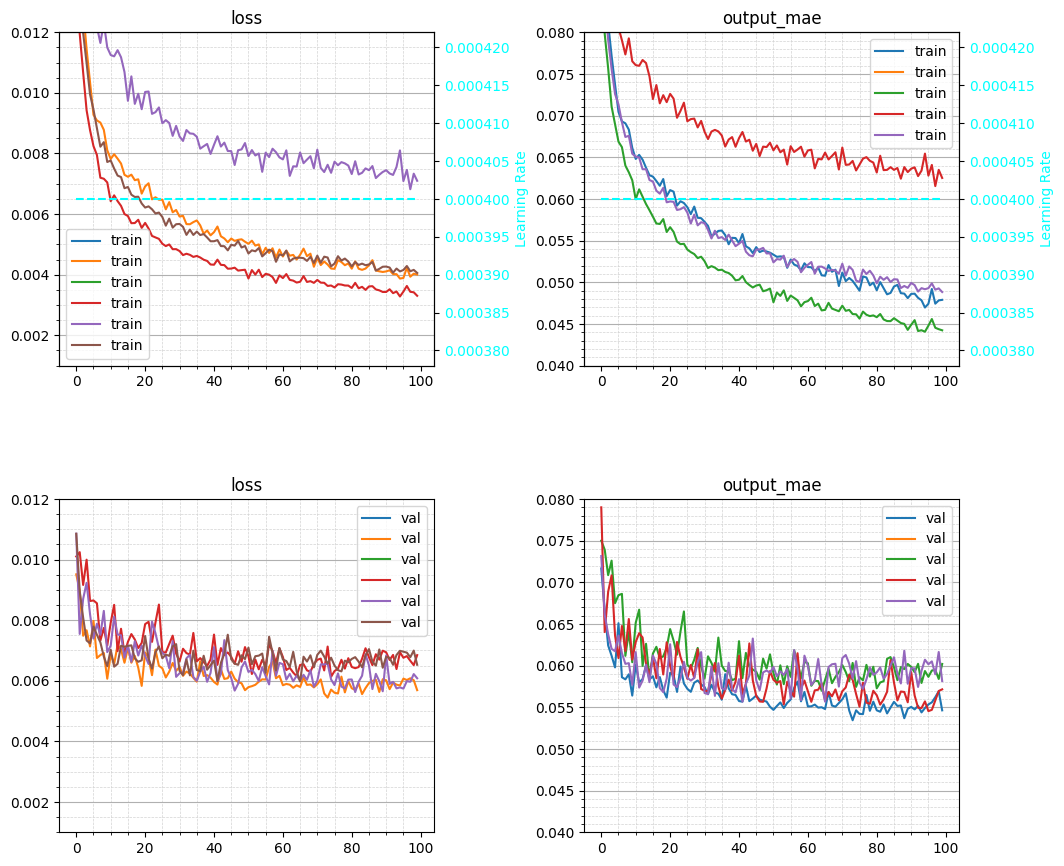

In [32]:
history = history_callback.history
history_1 = history_callback.history

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


ax = ax.ravel()

keys = list(history.keys())
for i in range(len(keys)):
    print(f"{i}: {keys[i]}")
needed = [0, 1]
groups = [keys[i] for i in needed]

groups[1] = "output_mae"

for key in history.keys():
    for j in range(len(groups)):
        if key.endswith(groups[j]):
            i = j
            if key.startswith("val"):
                i+=2
            label = "val" if key.startswith("val") else "train"
            ax[i].plot(history[key], label=label)
            ax[i].set_title(groups[j])
            ax[i].minorticks_on()
            ax[i].grid(True, axis="y")
            ax[i].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
            ax[i].legend()
            break

ylim_list = [
    (0.001, 0.012),
    (0.04, 0.08),
    (0.001, 0.012),
    (0.04, 0.08),
]
for i in range(len(ax)):
    # l, u = ylim_list[i]
    ax[i].set_ylim(ylim_list[i])

learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

for i in range(len(groups)):
    ax_lr = ax[i].twinx()
    ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
    ax_lr.set_ylabel("Learning Rate", color="cyan")
    ax_lr.tick_params(axis="y", labelcolor="cyan")


ax[0].legend(loc='lower left')

# ax[1].text(20 ,0,f"OverSampling max {upper}, v2S", rotation=90, ha='center')

# model_details_text = [
#     f"Model details: Batch {batch_size}, LR: {learning_rate}",
#     "EfficientNetV2S",
#     "two paths: ",
#     "GlobalAveragePooling2D+norm+dropout and ",
#     "conv2D(128,(3,3)) -> norm -> flatten",
#     "merge -> norm -> dense(2560) -> dropout",
#     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# ]

# ax[-1].axis("off")
# ax[-2].axis("off")
# ax[-3].axis("off")
# for i in range(len(model_details_text)):
#     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



plt.savefig(f"{folder_path}/{name_template}.png")

In [33]:
# for layer in base_model.layers[-5:]:  # Freeze all but the last 20 layers
#     layer.trainable = True

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#     loss={"angle_output": "mse"},
#     metrics={"angle_output": ["mae"]},
# )

# def lr_schedule_cont(epoch, lr):
#     return lr_schedule(epoch+NUM_OF_EPOCHS, lr)

# for epoch in range(30):
#     print(f"Epoch {epoch+1:2d}: {lr_schedule_cont(epoch, 0):.6f}")

# lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule_cont, verbose=1)

In [34]:
# try:
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=20,
#         steps_per_epoch= train_ds_length // batch_size,
#         validation_steps= val_ds_length // batch_size,
#         callbacks=[checkpoint, history_callback, lr_scheduler],
#         verbose=1,
#     )
# except KeyboardInterrupt:
#     print("Stopped early—saving history")
#     with open("training_history.pkl", "wb") as f:
#         pickle.dump(history_callback.history, f)

In [35]:
# name_template = f'{name_template}_cont'

# folder_path = f"Models/{name_template}"

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# filename = f"{folder_path}/{name_template}.keras"
# model.save(filename)
# filename = f"{folder_path}/{name_template}.weights.h5"
# model.save_weights(filename)

# history = history_callback.history

# filename = f"{folder_path}/{name_template}_history.pkl"
# with open(filename, 'wb') as f:
#     pickle.dump(history, f)

In [36]:
# history_2 = history_callback.history

# history = {}

# # Merge using numpy.concatenate
# for key in history_1.keys():
#     history[key] = np.concatenate([history_1[key], history_2[key]])

# history = history_callback.history

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


# ax = ax.ravel()

# keys = list(history.keys())
# print(keys)
# needed = [0, 1]
# groups = [keys[i] for i in needed]

# for key in history.keys():
#     for j in range(len(groups)):
#         if key.endswith(groups[j]):
#             label = "val" if key.startswith("val") else "train"
#             ax[j].plot(history[key], label=label)
#             ax[j].set_title(groups[j])
#             ax[j].minorticks_on()
#             ax[j].grid(True, axis="y")
#             ax[j].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
#             ax[j].legend()
#             break

# ylim_list = [
#     (0.001, 0.015),
#     (0.04, 0.08),
# ]
# for i in range(len(groups)):
#     # l, u = ylim_list[i]
#     ax[i].set_ylim(ylim_list[i])

# learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

# for i in range(len(groups)):
#     ax_lr = ax[i].twinx()
#     ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
#     ax_lr.set_ylabel("Learning Rate", color="cyan")
#     ax_lr.tick_params(axis="y", labelcolor="cyan")

# # ax[1].text(13 ,0,f"OverSampling max {upper}, v2M", rotation=90, ha='center')

# # model_details_text = [
# #     f"Model details: Batch {batch_size}, LR: {learning_rate}",
# #     "EfficientNetV2S",
# #     "two paths: ",
# #     "GlobalAveragePooling2D+norm+dropout and ",
# #     "conv2D(128,(3,3)) -> norm -> flatten",
# #     "merge -> norm -> dense(2560) -> dropout",
# #     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# # ]

# # ax[-1].axis("off")
# # ax[-2].axis("off")
# # ax[-3].axis("off")
# # for i in range(len(model_details_text)):
# #     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



# plt.savefig(f"{folder_path}/{name_template}.png")

In [37]:
print(len(history_1['loss']))

100


In [38]:
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=False)

pred = model.predict(val_ds)

2069/2069 [==============================] - 20s 9ms/step


In [39]:
pred
target_keys = ['angle1_output', 'angle2_output', 'angle5_output']
y_pred = []
for key in target_keys:
    y_pred.append(pred[key][:, 0])

y_pred_2 = np.mean(y_pred, axis=0)

[ 0.04312652  0.18350697  0.05997068 ...  0.02881558 -0.10263121
  0.09626323]


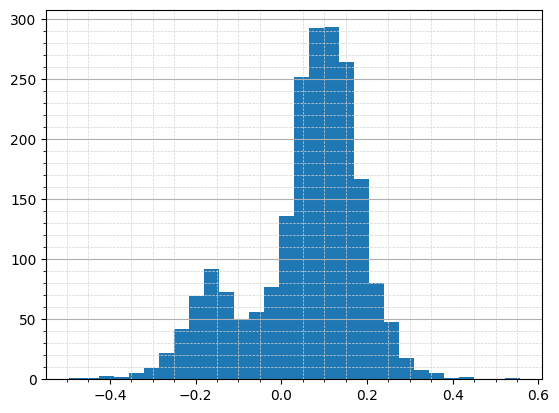

In [40]:
y_pred = y_pred_2
y_val

diff =  y_pred - y_val
print(diff)
plt.hist(diff, bins=30)
plt.minorticks_on()
plt.grid(True, axis="y")
plt.grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')

plt.savefig(f"diff_hist.png")